### Library Imports

In [1]:
from autoencoder import *
from dataloader import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os

In [2]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3[RGB], H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().numpy().transpose(1,2,0) # move the channel axis to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Building the data loader

These are transforms that allow us to ingest the image tensors with some extra confusion at training time. `processor` makes the data loader spit out tensors, and `noiser` adds Gaussian noise.

In [3]:
# This just processes the images.
H, W = 400, 400
processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    v2.Resize((H, W)), # resize
    lambda x: x / 255.0, # convert N[0, 255] to R[0.0, 1.0]
])

# This adds the noise for training.
NOISE_RATIO = 0.1
noiser = v2.Compose([
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0) # add the noise
])

In [4]:
root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset')
image_paths_file = os.path.join(root_directory, "leafsnap-dataset-images.txt")
dataset = LeafsnapDataset(image_paths_file, root_directory, use_segmented=False, source="field", transform=processor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## Training a fully convolutional autoencoder (CAE)

All parameters are hard-coded in this model. A 3x400x400 image is bound to a dense encoding of 5000 features, using only convolution.

In [5]:
model = ConvolutionalAutoencoder((32, 3, 400, 400), noiser)

train_AE_model(model, dataloader, 20, 1e-3)

Epoch 2/20:  86%|████████▌ | 208/242 [25:48<04:13,  7.44s/it, batch=208/242, loss=0.00273]


KeyboardInterrupt: 

Now, a test run of the reconstruction

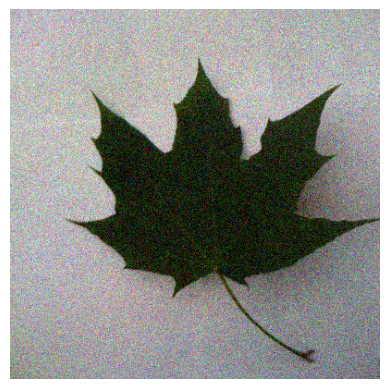

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1349428..0.8933213].


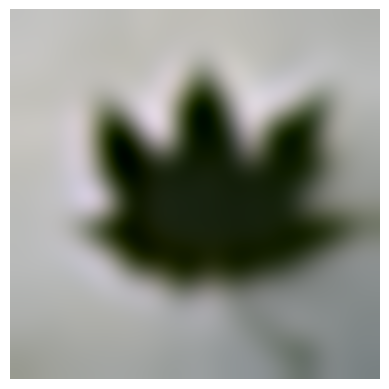

In [6]:
sample_train_image = noiser(dataset.__getitem__(300)[0].unsqueeze(0))
showTensorInNotebook(sample_train_image.squeeze(0))
reconstruction = model.forward(sample_train_image)
showTensorInNotebook(reconstruction.squeeze(0))

Had to stop it early, since it was taking forever on my CPU, but a decent demonstration.

In [7]:
torch.save(model.state_dict(), "CAE5k_model.pth")

## Building the classifier

In [ ]:
trained_autoencoder = ConvolutionalAutoencoder((32, 3, 400, 400), noiser)
trained_autoencoder.load_state_dict(torch.load('CAE5k_model.pth'))
trained_autoencoder.eval()

classifier = AEClassifier(trained_autoencoder.encoder, [5000, 500, 185])
for param in classifier.encoder.parameters():
    param.requires_grad = False

train_classifier_head(classifier, dataloader, 10, 1e-3)

In [6]:
# Accuracy computation (Top-1 and Top-5)
correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():  # No gradients needed for evaluation
    for inputs, labels in dataloader:
        outputs = classifier(inputs)  # Get model predictions
        
        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices  # Get top 5 predictions per sample
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()  # Check if label is in top 5

        total += labels.size(0)

# Print accuracies
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


c:\Users\rhkou\miniforge3\envs\DLProj\Lib\site-packages\torch\nn\modules\module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Top-1 Accuracy: 2.37%
Top-5 Accuracy: 9.53%


In [7]:
torch.save(classifier.state_dict(), "simple_AEclassifier.pth")

Oh yeah, it's big.

Seriously, though, random chance top-1 is 0.54%, so this is at least doing something.